### Домашня работа 2.
### Логистическая регрессия. Работа с признаками


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15 баллов. Можно получить 4.5 бонусных балла.

Неэффективная реализация кода может негативно отразиться на оценке.

In [13]:
print('Всем удачи!👒 Тут она точно пригодится.')

Всем удачи!👒 Тут она точно пригодится.


## Часть 1. Логистическая регрессия своими руками (4 балла)

Реализуйте логистическую регрессию, обучаемую с помощью:

**Задание 1 (1.5 балла). Градиентного спуска**

**Задание 2 (1.5 балла). Стохастического градиентного спуска**

Во всех пунктах необходимо соблюдать следующие условия:
- Градиентный спуск необходимо записать в векторном виде
- Циклы средствами python допускается использовать только для итераций градиентного спуска;
- В качестве критерия останова необходимо использовать (одновременно):

        проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) задаваемого параметром `tolerance`;


        достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса loss_history. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);

Инициализировать веса можно случайным образом или нулевым вектором.

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

In [1]:
%matplotlib inline
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification
from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic', 
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic' 
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration

    @staticmethod
    def _add_free_coefficient(X):
        # Добавляет столбец из единиц в конец матрицы признаков
        return np.column_stack((X, np.ones([X.shape[0], 1])))

    def _validate_and_prepare_feature_array(self, X):
        # Проверяет размер матрицы признаков X и добавляет столбец свободного
        # коэффициента при необходимости
        if X.shape[1] == (self.w.shape[0] - 1):
            X_prep = self._add_free_coefficient(X)
        elif X.shape[1] != self.w.shape[0]:
            raise Exception("Wrong X shape")
        else:
            X_prep = X

        return X_prep

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        if self.w0 is None:
            self.w0 = np.zeros(X.shape[1] + 1)
            self.w0[-1] = 1
        self.w = self.w0.copy()
        self.loss_history = []

        X_prep = self._validate_and_prepare_feature_array(X)

        for i in range(self.max_iter):
            if self.gd_type == "stochastic":
                r_ind = np.random.randint(0, X_prep.shape[0])
                grad = self.calc_gradient(X_prep[r_ind:r_ind+1], y[r_ind:r_ind+1])
            elif self.gd_type == "full":
                grad = self.calc_gradient(X_prep, y)
            else:
                raise NotImplementedError()

            if len(self.loss_history) == 0:
                loss = self.calc_loss(X_prep, y)
                self.loss_history.append(loss)

            w_dif = self.eta * grad
            self.w -= w_dif

            loss = self.calc_loss(X_prep, y)
            self.loss_history.append(loss)

            if np.linalg.norm(w_dif) < self.tolerance:
                break

        return self

    def predict_proba(self, X):
        if self.w is None:
            raise Exception("Not trained yet")
        X_prep = self._validate_and_prepare_feature_array(X)
        p = 1 / (1 + np.exp(-np.dot(X_prep, self.w)))

        return p

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        p = self.predict_proba(X)

        return (p >= 0.5).astype(int)

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        X_prep = self._validate_and_prepare_feature_array(X)
        proba = self.predict_proba(X_prep)
        grad = - 1/X_prep.shape[0] * np.dot(X_prep.T, (y - proba))
        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """
        proba = self.predict_proba(X)
        loss = - np.mean(y * np.log(proba) + (1 - y) * np.log(1 - proba))
        return loss

Синтетические данные

In [5]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

**Задание 3 (1 балл)**

Обучите логистическую регрессию на синтетических данных.

In [6]:
np.random.seed(42)

lr = LogReg(gd_type="full")
lr.fit(X_train, y_train)

LogReg(gd_type='full',
       w0=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1.]))

In [3]:
def plot_loss_history(loss_history: list[float], title: str = None):
    title = title or "Log loss History"
    plt.plot(loss_history)
    plt.xlabel("Iteration number")
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()

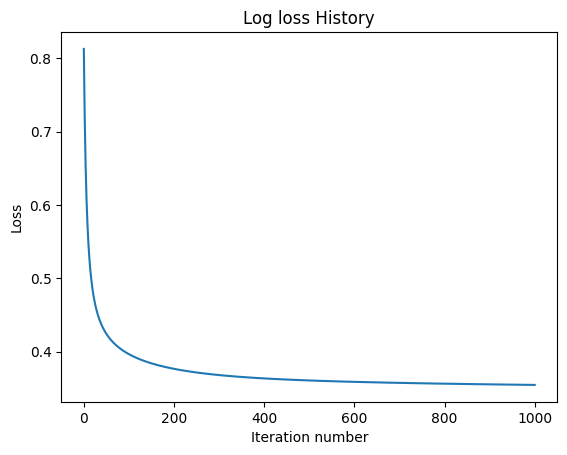

In [16]:
plot_loss_history(lr.loss_history)

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

In [17]:
prediction_proba = lr.predict_proba(X_test)

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, prediction_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC_AUC = {roc_auc}")

ROC_AUC = 0.9249218648318791


In [4]:
def plot_roc_curve(fpr, tpr, auc, thresholds, thresholds_step=500):
    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve (auc = %0.2f)" % auc)
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

    indices_to_annotate = np.arange(len(thresholds), step=thresholds_step)
    for idx in indices_to_annotate:
        threshold = str(round(thresholds[idx], 2))
        plt.annotate(threshold, (fpr[idx], tpr[idx]), textcoords="offset points",
                     xytext=(-2, 10), ha="center")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.ylim([0.0, 1.1])
    plt.legend(loc="lower right")
    plt.title("ROC Curve with Thresholds")
    plt.show()

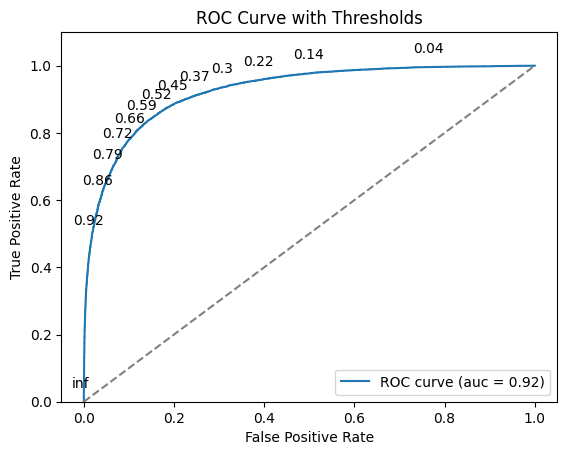

In [20]:
plot_roc_curve(fpr, tpr, roc_auc, thresholds)

Модель делает предсказания значительно лучше случайного угадывания (выше диагональной пунктирной линии). Если требуется минимизировать количество ложно положительных случаев, нужно искать ближайшую к левому верхнему углу точку на графике. Это точка с порогом приблизительно 0.6 и TPR 0.82 - 0.84. ROC AUC = 0.92 - довольно высокий показатель.

In [22]:
pr, rc, pr_thresholds = precision_recall_curve(y_test, prediction_proba)
pr_auc = average_precision_score(y_test, prediction_proba)
print(f"PR_AUC = {pr_auc:.2f}")

PR_AUC = 0.93


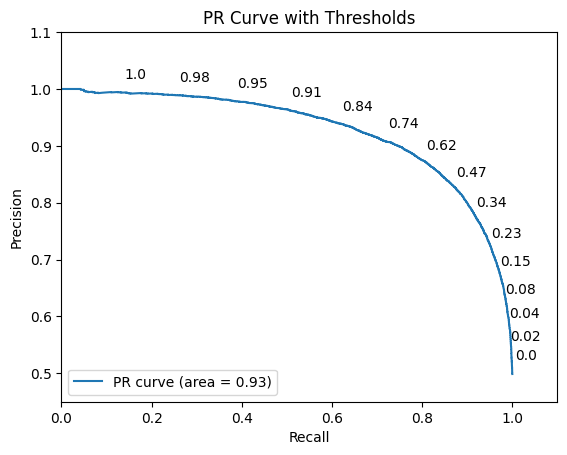

In [23]:
plt.figure()
plt.plot(rc, pr, label="PR curve (area = %0.2f)" % pr_auc)

indices_to_annotate = np.arange(len(pr_thresholds), step=2000)
for idx in indices_to_annotate:
    threshold = str(round(pr_thresholds[idx], 2))
    plt.annotate(threshold, (rc[idx], pr[idx]), textcoords="offset points",
                 xytext=(10, 10), ha="center")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.45, 1.1])
plt.xlim([0., 1.1])
plt.legend(loc="lower left")
plt.title("PR Curve with Thresholds")
plt.show()

Эта метрика особенно полезна, если есть сильный дисбаланс классов. В таком случае она показывает более адекватные значения по сравнению с ROC AUC. По графику можно увидеть, что при пороге около 0.6 модель показывает точность 0.9 и полноту приблизительно 0.8. В области порога 0.4 происходит перегиб графика. При движении влево полнота падает быстрее, чем растет точность. При движении вправо - точность падает значительно быстрее, чем растет полнота. В зависимости от приоритета (точность или полнота) на графике удобно выбирать оптимальный порог, дающий сбалансированное сочетание полноты и точности. Можно немного проиграть в одном параметре и сильно выиграть в другом.

## Часть 2. Работа с категориальными переменными (3 балла)

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные с конкурса  [Kaggle Porto Seguro’s Safe Driver Prediction](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction) (вам нужна только обучающая выборка). Задача состоит в определении водителей, которые в ближайший год воспользуются своей автомобильной страховкой (бинарная классификация). Но для нас важна будет не сама задача, а только её данные. При этом для задания мы немного модифицируем датасет.

In [24]:
data = pd.read_csv('train.csv', index_col=0)
data_with_target = data.copy()
target = data.target.values
data = data.drop('target', axis=1)

Пересемплируем выборку так, чтобы положительных и отрицательных объектов в выборке было одинаковое число. Разделим на обучающую и тестовую выборки.


In [25]:
# some resampling
np.random.seed(910)
mask_plus = np.random.choice(np.where(target == 1)[0], 100000, replace=True)
mask_zero = np.random.choice(np.where(target == 0)[0], 100000, replace=True)

data = pd.concat((data.iloc[mask_plus], data.iloc[mask_zero]))
target = np.hstack((target[mask_plus], target[mask_zero]))

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5)

In [26]:
count_by_target = data_with_target.groupby("target")["ps_ind_01"].count()
count_by_target

target
0    573518
1     21694
Name: ps_ind_01, dtype: int64

Тээкс... похоже во всей выборке всего 21 тысяча строк с таргетом = 1. А значит, если выбирать 100 000 из датасета, то неизбежно будут дубли. Мне представляется более оптимальным уменьшить размер выборки с 200 000 до 40 000. Но не буду менять условия задания. Однако отмечу, что провел сравнительное обучение модели на 40 000 строк и метрики получились практически идентичные.

**Задание 5 (0 баллов).** Посчитайте качество (в этом задании будем работать c ROC-AUC) на исходных признаках при применении логистической регрессии.

In [27]:
lr = LogReg(tolerance=1e-8, max_iter=1000, gd_type="full", eta=0.001)
lr.fit(X_train, y_train)

LogReg(eta=0.001, gd_type='full', tolerance=1e-08,
       w0=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1.]))

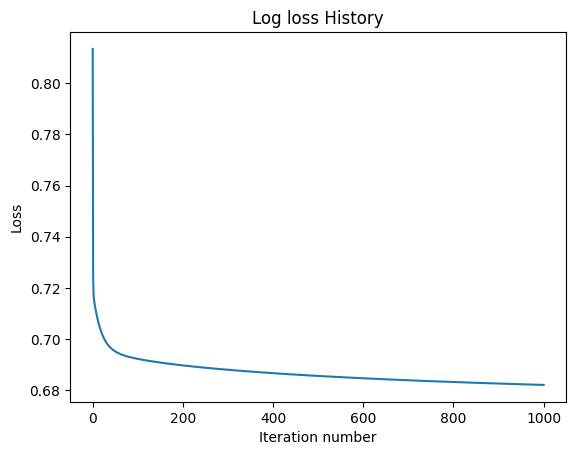

In [28]:
plot_loss_history(lr.loss_history)

In [30]:
pred_proba = lr.predict_proba(X_test)

ROC_AUC = 0.58


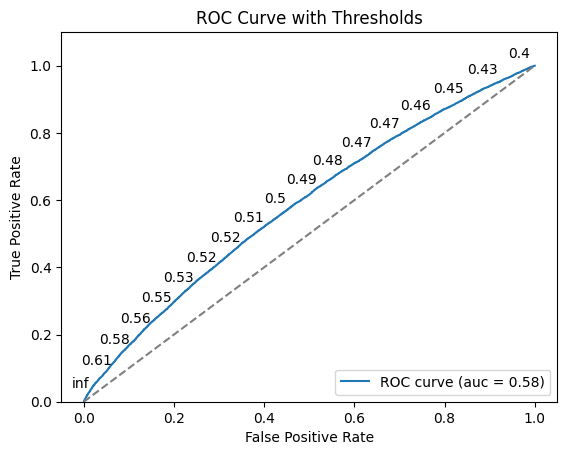

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC_AUC = {roc_auc:.2f}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 2000)

**Задание 6 (0.5 балла).** Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на обучение модели.

In [5]:
def perform_one_hot_encoding(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_encode = [col for col in df.columns
                      if col.endswith("_cat") and df[col].nunique() > 2]
    df_encoded = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)
    for col in df_encoded.columns:
        if df_encoded[col].dtype == "bool":
            df_encoded[col] = df_encoded[col].astype(int)
    return df_encoded

In [34]:
X_train_enc = perform_one_hot_encoding(X_train)
X_test_enc = perform_one_hot_encoding(X_test)

In [35]:
lr = LogReg(tolerance=1e-8, max_iter=3000, gd_type="full", eta=0.01)

start_time = time.time()
lr.fit(X_train_enc, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Модель на признаках с one-hot кодированием")
print(f"Время обучения модели: {elapsed_time} с")

Модель на признаках с one-hot кодированием
Время обучения модели: 29.905778884887695 с


In [36]:
pred_proba = lr.predict_proba(X_test_enc)

ROC_AUC = 0.63


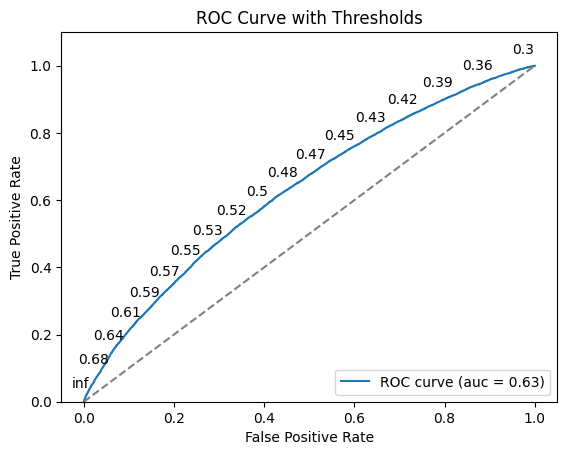

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
roc_auc = auc(fpr, tpr)
print(f"ROC_AUC = {roc_auc:.2f}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 2000)

Метрика ROC AUC модели с one-hot кодированием выросла на 0.05 по сравнению с базовой моделью

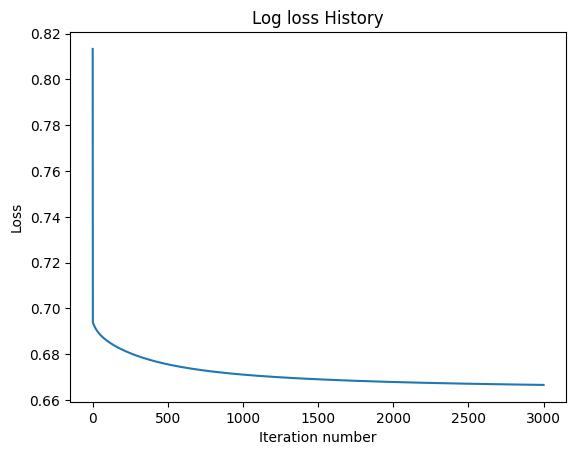

In [39]:
plot_loss_history(lr.loss_history)

Как можно было заменить, one-hot-кодирование сильно увилечивает количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирование категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 7 (1.5 балла).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущим экспериментом. Заметили ли вы что-то интересное?


In [6]:
def encode_column_mean_target(df: pd.DataFrame, feature_name: str,
                              target: np.ndarray) -> pd.DataFrame:
    series_target = pd.Series(target, name="target")
    encoded_feature = pd.concat([df[feature_name], series_target], axis=1)
    means = encoded_feature.groupby(feature_name)["target"].mean()
    encoded_feature = df[feature_name].map(means)
    return encoded_feature

In [7]:
def perform_df_mean_target_encoding(df: pd.DataFrame, target: np.ndarray) -> pd.DataFrame:
    df_enc = df.copy()
    cols_to_encode = [col for col in df.columns
                      if col.endswith("_cat") and df[col].nunique() > 2]
    for col in cols_to_encode:
        df_enc[col] = encode_column_mean_target(df, col, target)
    return df_enc

In [43]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [44]:
X_train_enc = perform_df_mean_target_encoding(X_train, y_train)

In [45]:
X_test_enc = perform_df_mean_target_encoding(X_test, y_test)

In [46]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 57 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ps_ind_01       100000 non-null  int64  
 1   ps_ind_02_cat   100000 non-null  float64
 2   ps_ind_03       100000 non-null  int64  
 3   ps_ind_04_cat   100000 non-null  float64
 4   ps_ind_05_cat   100000 non-null  float64
 5   ps_ind_06_bin   100000 non-null  int64  
 6   ps_ind_07_bin   100000 non-null  int64  
 7   ps_ind_08_bin   100000 non-null  int64  
 8   ps_ind_09_bin   100000 non-null  int64  
 9   ps_ind_10_bin   100000 non-null  int64  
 10  ps_ind_11_bin   100000 non-null  int64  
 11  ps_ind_12_bin   100000 non-null  int64  
 12  ps_ind_13_bin   100000 non-null  int64  
 13  ps_ind_14       100000 non-null  int64  
 14  ps_ind_15       100000 non-null  int64  
 15  ps_ind_16_bin   100000 non-null  int64  
 16  ps_ind_17_bin   100000 non-null  int64  
 17  ps_ind_18_b

Количество колонок не увеличилось по сравнению с one-hot кодированием, где их стало 213

In [47]:
lr = LogReg(tolerance=1e-8, max_iter=3000, gd_type="full", eta=0.01)

start_time = time.time()
lr.fit(X_train_enc, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print("Модель на признаках закодированных методом mean target")
print(f"Время обучения модели: {elapsed_time} с")

Модель на признаках закодированных методом mean target
Время обучения модели: 19.752849102020264 с


20 с против 30 с для модели с one-hot кодированием

In [48]:
pred_proba_train = lr.predict_proba(X_train_enc)
pred_proba_test = lr.predict_proba(X_test_enc)

Метрики модели на тренировочных данных
ROC_AUC = 0.61


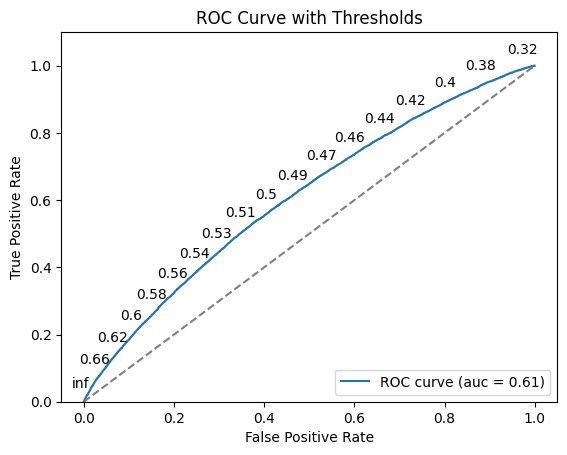

In [50]:
fpr, tpr, thresholds = roc_curve(y_train, pred_proba_train)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тренировочных данных")
print(f"ROC_AUC = {roc_auc:.2f}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 2000)

Метрики модели на тестовых данных
ROC_AUC = 0.61


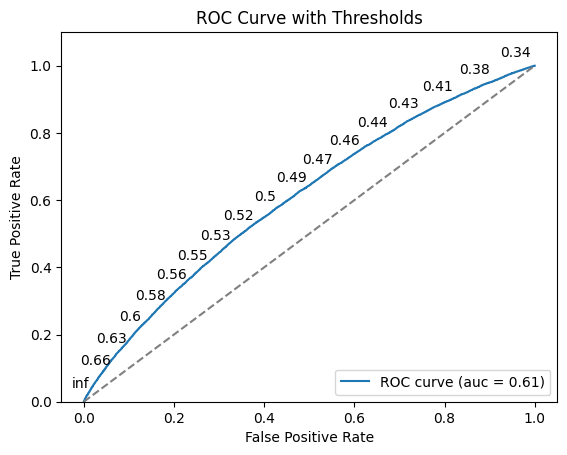

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тестовых данных")
print(f"ROC_AUC = {roc_auc:.2f}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 2000)

ROC AUC на 0.03 лучше базовой и на 0.02 хуже модели с one-hot кодированием. Значения метрики одинаково посредственные на тренировочных и тестовых данных. Признаков переобучения нет.

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо так, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 8 (1 балл)__. Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (необходимо соблюсти баланс между избавление от переобучения и полезностью признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.


In [8]:
def encode_column_mean_target_with_noise(df: pd.DataFrame, feature_name: str,
                                         target: np.ndarray, noise_level=0.01) -> pd.DataFrame:
    series_target = pd.Series(target, name="target")
    encoded_feature = pd.concat([df[feature_name], series_target], axis=1)
    means = encoded_feature.groupby(feature_name)["target"].mean()
    encoded_feature = df[feature_name].map(means) + noise_level * np.random.randn(len(df))
    return encoded_feature

In [9]:
def perform_df_mean_target_encoding_with_noise(df: pd.DataFrame, target: np.ndarray) -> pd.DataFrame:
    df_enc = df.copy()
    cols_to_encode = [col for col in df.columns
                      if col.endswith("_cat") and df[col].nunique() > 2]
    for col in cols_to_encode:
        df_enc[col] = encode_column_mean_target_with_noise(df, col, target)
    return df_enc

In [54]:
X_train_enc_noise = perform_df_mean_target_encoding_with_noise(X_train, y_train)
X_test_enc_noise = perform_df_mean_target_encoding_with_noise(X_test, y_test)

In [55]:
lr = LogReg(tolerance=1e-8, max_iter=3000, gd_type="full", eta=0.01)

start_time = time.time()
lr.fit(X_train_enc_noise, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Модель на признаках закодированных методом mean target с добавлением шума")
print(f"Время обучения модели: {elapsed_time} с")

Модель на признаках закодированных методом mean target с добавлением шума
Время обучения модели: 18.129228115081787 с


In [56]:
pred_proba_train = lr.predict_proba(X_train_enc)
pred_proba_test = lr.predict_proba(X_test_enc)

Метрики модели на тренировочных данных
ROC_AUC = 0.61


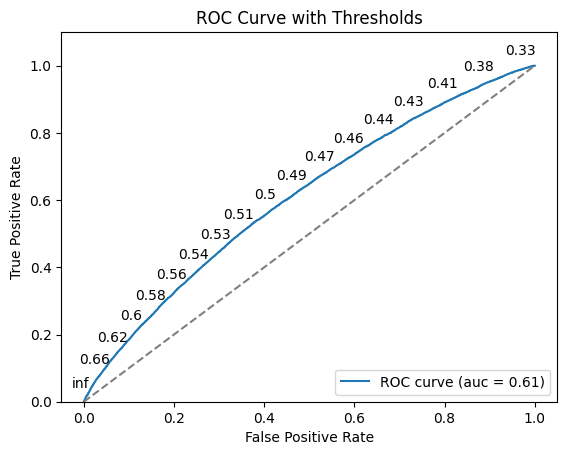

In [57]:
fpr, tpr, thresholds = roc_curve(y_train, pred_proba_train)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тренировочных данных")
print(f"ROC_AUC = {roc_auc:.2f}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 2000)

Метрики модели на тестовых данных
ROC_AUC = 0.61


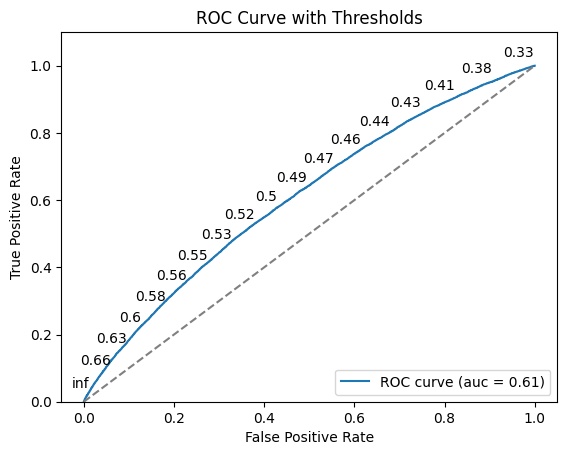

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тестовых данных")
print(f"ROC_AUC = {roc_auc:.2f}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 2000)

Терзают смутные сомнения, может быть я где-то допустил ошибку. По-идее, в предыдущем пункте моя модель должна была переобучиться и это проблему удалось бы решить при помощи добавления шума. Но у меня все одинаково что там, что здесь :)

## Часть 3. Отбор признаков (3 балла + 1 бонус)

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом они увеличивают время вычислений) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про обращение клиентов по страховым случаям. Обойдёмся без сэмплирования объектов.

In [10]:
data = pd.read_csv('train.csv', index_col=0)
target = data.target.values
data = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

Как вы помните, в данных много категориальных признаков. Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [11]:
X_train_one_hot = perform_one_hot_encoding(X_train)
X_test_one_hot = perform_one_hot_encoding(X_test)
print(f"Количество признаков после one-hot кодирования = {len(X_train_one_hot.columns)}")

Количество признаков после one-hot кодирования = 213


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — ROC-AUC. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [12]:
lr = LogReg(tolerance=1e-8, max_iter=3000, gd_type="full", eta=0.01)

start_time = time.time()
lr.fit(X_train_one_hot, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Время обучения модели: {elapsed_time} с")

Время обучения модели: 120.97241592407227 с


In [13]:
pred_proba_train = lr.predict_proba(X_train_one_hot)
pred_proba_test = lr.predict_proba(X_test_one_hot)

Метрики модели на тренировочных данных
ROC_AUC = 0.5663872561300894


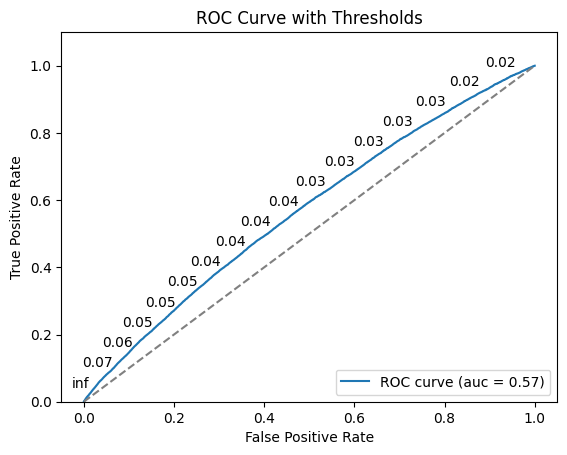

In [14]:
fpr, tpr, thresholds = roc_curve(y_train, pred_proba_train)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тренировочных данных")
print(f"ROC_AUC = {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 2000)

Метрики модели на тестовых данных
ROC_AUC = 0.5636725776437089


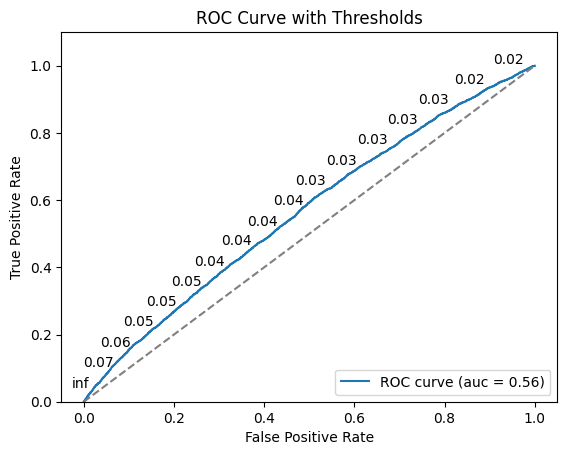

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тестовых данных")
print(f"ROC_AUC = {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 500)

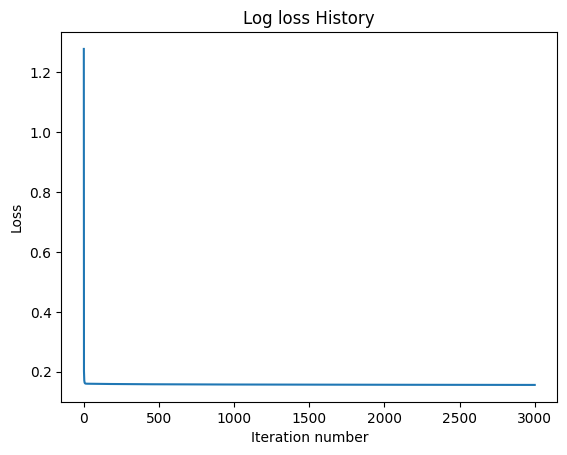

In [15]:
plot_loss_history(lr.loss_history)

### Встроенные методы

Допустим, мы хотим оставить только 200 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отбора признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 10 (1 балл).__ Оставьте 200 признаков с наибольшим модулем соответсвующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?

In [17]:
smallest_w_indexes = np.argpartition(np.abs(lr.w[:-1]), 13)[:13]
smallest_w_indexes

array([110, 144, 109,  60, 142, 189,   6, 143, 199,   9, 200,  90, 122])

In [18]:
X_train_reduced_embedded = X_train_one_hot.drop(X_train_one_hot.columns[smallest_w_indexes], axis=1)
X_test_reduced_embedded = X_test_one_hot.drop(X_test_one_hot.columns[smallest_w_indexes], axis=1)

In [19]:
X_train_reduced_embedded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 476169 entries, 381341 to 1158078
Columns: 200 entries, ps_ind_01 to ps_car_11_cat_104
dtypes: float64(10), int64(190)
memory usage: 730.2 MB


In [20]:
lr = LogReg(tolerance=1e-8, max_iter=3000, gd_type="full", eta=0.01)

start_time = time.time()
lr.fit(X_train_reduced_embedded, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Время обучения модели: {elapsed_time} с")

Время обучения модели: 115.26484394073486 с


In [21]:
pred_proba_train = lr.predict_proba(X_train_reduced_embedded)
pred_proba_test = lr.predict_proba(X_test_reduced_embedded)

Метрики модели на тренировочных данных
ROC_AUC = 0.5663871004341311


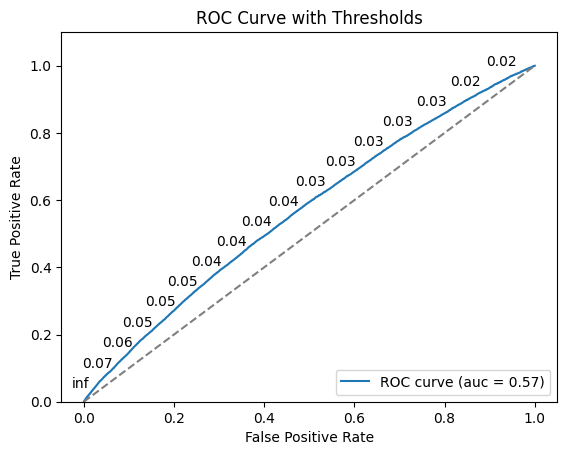

In [22]:
fpr, tpr, thresholds = roc_curve(y_train, pred_proba_train)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тренировочных данных")
print(f"ROC_AUC = {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 2000)

Метрики модели на тестовых данных
ROC_AUC = 0.5636728156843062


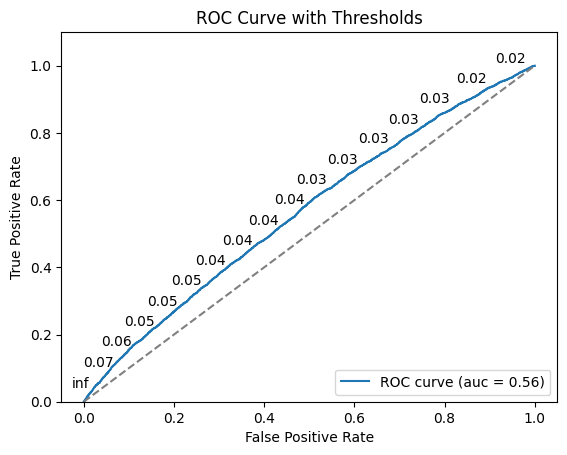

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тестовых данных")
print(f"ROC_AUC = {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 500)

Отбор признаков не изменил метрики качества

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отнормируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [24]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    data=scaler.fit_transform(X_train_one_hot),
    columns=X_train_one_hot.columns,
)
X_test_scaled = pd.DataFrame(
    data=scaler.fit_transform(X_test_one_hot),
    columns=X_test_one_hot.columns,
)

In [25]:
lr = LogReg(tolerance=1e-8, max_iter=3000, gd_type="full", eta=0.01)

start_time = time.time()
lr.fit(X_train_scaled, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Время обучения модели: {elapsed_time} с")

Время обучения модели: 121.47507500648499 с


In [26]:
pred_proba_train = lr.predict_proba(X_train_scaled)
pred_proba_test = lr.predict_proba(X_test_scaled)

Метрики модели на тренировочных данных
ROC_AUC = 0.6323050454111614


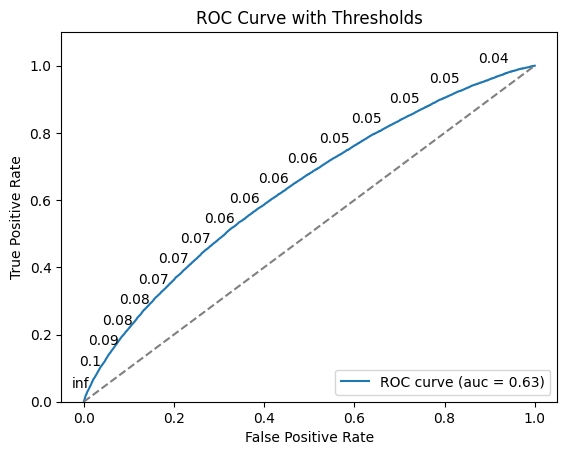

In [27]:
fpr, tpr, thresholds = roc_curve(y_train, pred_proba_train)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тренировочных данных")
print(f"ROC_AUC = {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 2000)

Метрики модели на тестовых данных
ROC_AUC = 0.6369586910923808


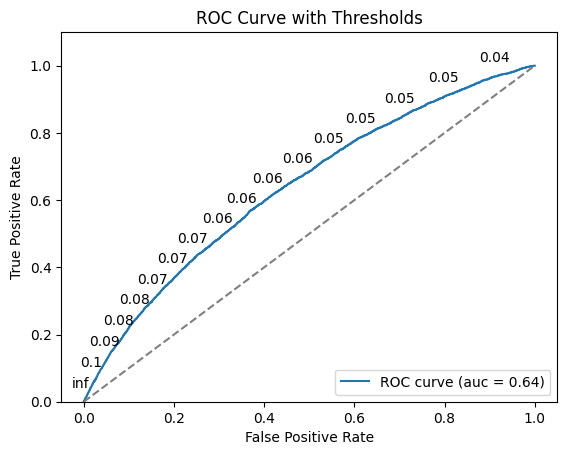

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тестовых данных")
print(f"ROC_AUC = {roc_auc}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 500)

Нормирование улучшило метрики модели

In [29]:
smallest_w_indexes = np.argpartition(np.abs(lr.w[:-1]), 13)[:13]
smallest_w_indexes

array([181,  38,  41,  62,  43, 172,  30, 144,  58,   9,  28, 137, 121])

In [30]:
X_train_scaled_embedded = X_train_scaled.drop(X_train_scaled.columns[smallest_w_indexes], axis=1)
X_test_scaled_embedded = X_test_scaled.drop(X_test_scaled.columns[smallest_w_indexes], axis=1)

In [31]:
lr = LogReg(tolerance=1e-8, max_iter=3000, gd_type="full", eta=0.01)

start_time = time.time()
lr.fit(X_train_scaled_embedded, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Время обучения модели: {elapsed_time} с")

Время обучения модели: 118.08517503738403 с


In [32]:
pred_proba_train = lr.predict_proba(X_train_scaled_embedded)
pred_proba_test = lr.predict_proba(X_test_scaled_embedded)

Метрики модели на тренировочных данных
ROC_AUC = 0.63


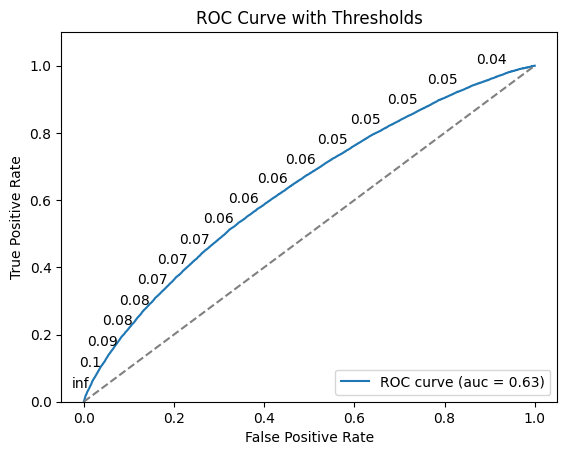

In [34]:
fpr, tpr, thresholds = roc_curve(y_train, pred_proba_train)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тренировочных данных")
print(f"ROC_AUC = {roc_auc:.2f}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 2000)

Метрики модели на тестовых данных
ROC_AUC = 0.64


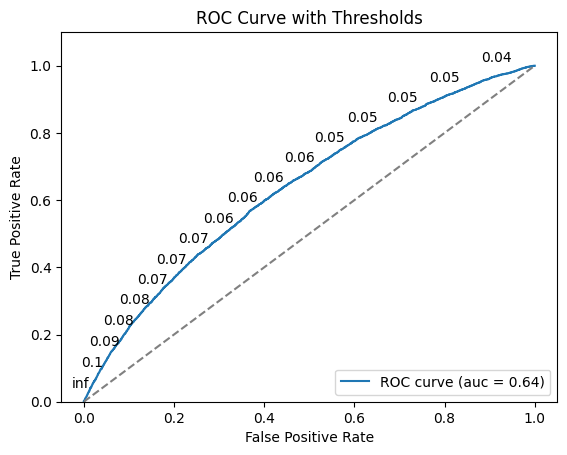

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тестовых данных")
print(f"ROC_AUC = {roc_auc:.2f}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 500)

Удалось сократить количество метрик до 200 сохранив метрики на том же уровне

__Задание 10 (0.5 балла).__
Можно задать отбор признаков более функционально. Вспомним, что L1-регуляризация также умеет отбирать признаки. Понятно, что теперь нам будет сложнее оставить именно 200 лучших признаков, но возможно они нам и не нужны. Подберите коэффициент регуляризации и проверьте, как изменилось качество. Получилось ли добиться лучшего качества при менее чем 200 признаках?

In [20]:
sgd = SGDClassifier(loss="log_loss", penalty="l1")
param_grid = {"alpha": [0.0001, 0.001, 0.01]}
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring="roc_auc")

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SGDClassifier(loss='log_loss', penalty='l1'),
             param_grid={'alpha': [0.0001, 0.001, 0.01]}, scoring='roc_auc')

In [21]:
grid_search.best_params_

{'alpha': 0.0001}

In [22]:
grid_search.best_score_

0.6232489178508891

In [37]:
sgd = SGDClassifier(alpha=0.0001, loss="log_loss", penalty="l1")
sgd.fit(X_train_scaled, y_train)

SGDClassifier(loss='log_loss', penalty='l1')

In [38]:
zero_coef_indices = np.where(sgd.coef_ == 0)
zero_coef_indices[1]

array([  5,   6,   7,   8,   9,  10,  14,  18,  19,  24,  25,  27,  28,
        29,  30,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  45,  47,  56,  57,  58,  59,  60,  61,  65,  66,  69,  70,
        73,  75,  77,  79,  80,  82,  83,  84,  86,  88,  89,  92,  93,
        94,  95,  96,  98, 102, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 116, 117, 118, 119, 120, 121, 122, 127, 128, 132, 134, 135,
       136, 137, 138, 143, 144, 145, 146, 148, 150, 152, 153, 155, 156,
       158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 175,
       176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 189, 190,
       191, 192, 193, 194, 197, 198, 199, 200, 202, 204, 205, 206, 208,
       210, 211, 212])

In [39]:
X_train_scaled_l1 = X_train_scaled.drop(X_train_scaled.columns[zero_coef_indices[1]], axis=1)
X_test_scaled_l1 = X_test_scaled.drop(X_test_scaled.columns[zero_coef_indices[1]], axis=1)

In [40]:
X_test_scaled_l1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119043 entries, 0 to 119042
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ps_ind_01          119043 non-null  float64
 1   ps_ind_03          119043 non-null  float64
 2   ps_ind_06_bin      119043 non-null  float64
 3   ps_ind_07_bin      119043 non-null  float64
 4   ps_ind_08_bin      119043 non-null  float64
 5   ps_ind_15          119043 non-null  float64
 6   ps_ind_16_bin      119043 non-null  float64
 7   ps_ind_17_bin      119043 non-null  float64
 8   ps_reg_01          119043 non-null  float64
 9   ps_reg_02          119043 non-null  float64
 10  ps_reg_03          119043 non-null  float64
 11  ps_car_12          119043 non-null  float64
 12  ps_car_13          119043 non-null  float64
 13  ps_car_14          119043 non-null  float64
 14  ps_car_15          119043 non-null  float64
 15  ps_calc_03         119043 non-null  float64
 16  ps

In [41]:
lr = LogReg(tolerance=1e-8, max_iter=3000, gd_type="full", eta=0.01)

start_time = time.time()
lr.fit(X_train_scaled_l1, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Время обучения модели: {elapsed_time} с")

Время обучения модели: 76.53429388999939 с


In [42]:
pred_proba_train = lr.predict_proba(X_train_scaled_l1)
pred_proba_test = lr.predict_proba(X_test_scaled_l1)

Метрики модели на тренировочных данных
ROC_AUC = 0.63


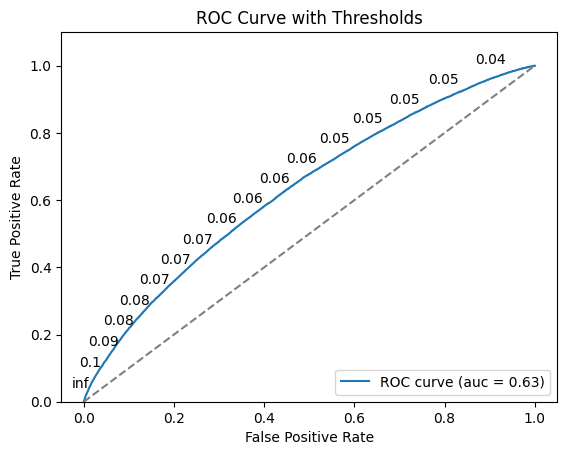

In [44]:
fpr, tpr, thresholds = roc_curve(y_train, pred_proba_train)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тренировочных данных")
print(f"ROC_AUC = {roc_auc:.2f}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 2000)

Метрики модели на тестовых данных
ROC_AUC = 0.63


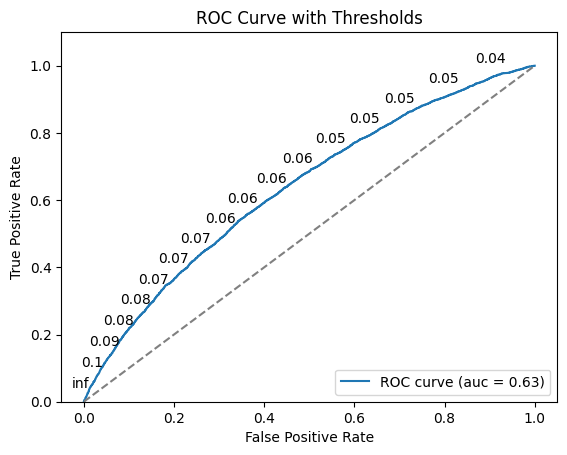

In [45]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тестовых данных")
print(f"ROC_AUC = {roc_auc:.2f}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 500)

Удалось сократить количество признаков с 213 до 80, сохранив метрики почти без изменений.

### Методы фильтрации

Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $mu$, $sigma$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

Если у вас был курс математической статистики, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях. Если же нет, то интуиция следующая. Вообще мы хотим понять, различаются ли распределения признака для двух разных классов. Мы проверяем, что математические ожидания двух распределений различаются. Если они различаются, значит и сами распределения разные. Отсюда можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и статистика маленькая, то и признак бесполезен. 

Важно оговориться, что хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и n велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются. По-хорошему, конечно, надо бы сравнивать статистику с пороговым значением t-распределения и полноценно тестировать гипотезу, но мы обойдёмся простой эвристикой и возьмём признаки с наибольшим значением.


__Задание 11 (1 балл)__. Оставьте 200 признаков с наибольшим значением и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случаев.

In [46]:
def calc_feature_t_statistics(df: pd.DataFrame, target: np.ndarray) -> np.ndarray:
    class_plus = df[target == 1]
    class_minus = df[target == 0]
    t_statistics = np.zeros(df.shape[1])
    n_plus = class_plus.shape[0]
    n_minus = class_minus.shape[0]

    for ind, feature in enumerate(df.columns):
        mu_plus = class_plus[feature].mean()
        mu_minus = class_minus[feature].mean()
        # в формуле среднеквадратичное отклонение возведено в квадрат - это дисперсия
        var_plus = np.var(class_plus[feature])
        var_minus = np.var(class_minus[feature])

        t_stat = np.abs(mu_plus - mu_minus) / np.sqrt(
            (n_plus * var_plus + n_minus * var_minus) / (df.shape[0])
        )
        t_statistics[ind] = t_stat

    return t_statistics

In [49]:
ts = calc_feature_t_statistics(X_train_scaled, y_train)
smallest_ts_indexes = np.argpartition(ts, 13)[:13]
X_train_scaled_ts = X_train_scaled.drop(X_train_scaled.columns[smallest_ts_indexes], axis=1)
X_test_scaled_ts = X_test_scaled.drop(X_test_scaled.columns[smallest_ts_indexes], axis=1)

In [50]:
lr = LogReg(tolerance=1e-8, max_iter=3000, gd_type="full", eta=0.01)

start_time = time.time()
lr.fit(X_train_scaled_ts, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Время обучения модели: {elapsed_time} с")

Время обучения модели: 120.8384439945221 с


In [51]:
pred_proba_train = lr.predict_proba(X_train_scaled_ts)
pred_proba_test = lr.predict_proba(X_test_scaled_ts)

Метрики модели на тренировочных данных
ROC_AUC = 0.63


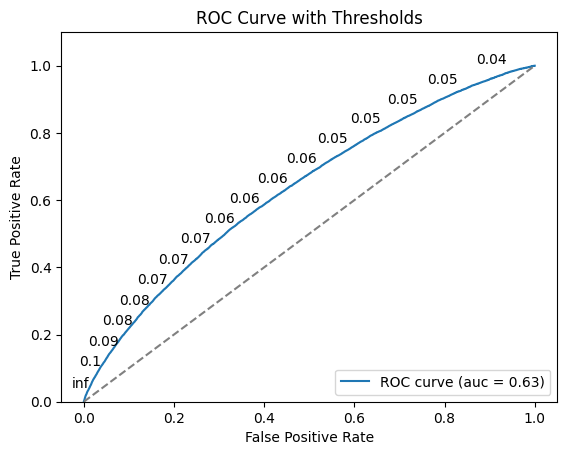

In [52]:
fpr, tpr, thresholds = roc_curve(y_train, pred_proba_train)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тренировочных данных")
print(f"ROC_AUC = {roc_auc:.2f}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 2000)

Метрики модели на тестовых данных
ROC_AUC = 0.64


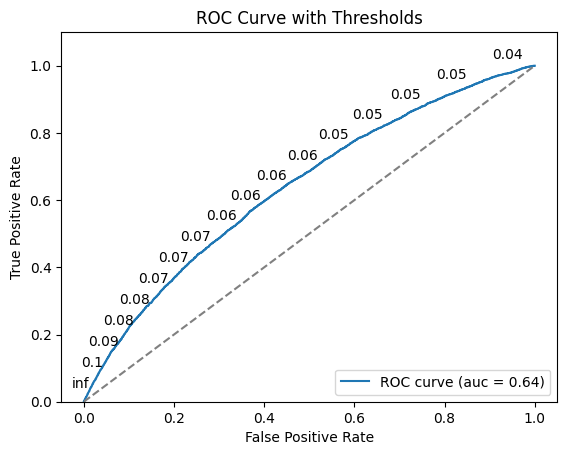

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test)
roc_auc = auc(fpr, tpr)
print("Метрики модели на тестовых данных")
print(f"ROC_AUC = {roc_auc:.2f}")
plot_roc_curve(fpr, tpr, roc_auc, thresholds, 500)

Метрики такие же как и при embedded кодировании

### Методы-обёртки

__Задание 12 (бонус, 1 балл)__.


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не достигнем некоторого критерия (количество признаков или ухудшением качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо. 

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 200 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


**Задание 13 (0.5 балла)** Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

**Ответ:** ...

На полученных данных сравнивать методы затруднительно. Embedded и метод фильтрации дали одинаковые метрики ROC AUC. По количеству отобранных признаков и скорости работы - идентично. Среди проведенных мною экспериментов по фильтрации я скорее готов выделить L1 регуляризацию, после которой осталось всего 90 признаков, но метрики почти не упали. Однако, нужно заметить, что во всех случая метрики одинаково посредственные и не превышают 0.64. А разница между ними колеблется в предела нескольких сотых пунктов. Чтобы сделать более существенные выводы нужны также более детальные исследования, которые я провести не успел, к сожалению.
